Goal is to show the necessity of nCL to identify RBPs, since CL alone just correlates with abundance

---

In [1]:
%cd ../../../../

/home/k.rooijers/Projects/OOPS_2023


/home/k.rooijers/.cache/pypoetry/virtualenvs/oops-2023-mKfZaHlF-py3.11/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


---

In [2]:
import numpy as np
import pandas as pd

In [3]:
import seaborn

In [4]:
import duckdb

import blitzgsea

In [5]:
%matplotlib inline

In [6]:
from matplotlib import pyplot as plt

In [7]:
import xarray

In [8]:
np.random.seed(42)

In [9]:
def sluggify(s):
    from string import ascii_letters, digits
    return "".join(c for c in s if c in ascii_letters or c in digits or c in "-_."
    ).replace(":", "_").replace("-", "_").replace(".", "_")

---

### Data loading

In [10]:
sample_subset = pd.read_csv("pipeline_activation/samplesheet.tsv", sep="\t")

In [11]:
intensities = pd.read_csv(
    "pipeline_activation/intensity-values.tsv",
    sep="\t", index_col=0,
)

In [12]:
w_valid = intensities['w_valid']

In [13]:
hgnc_metadata = pd.read_csv(
    "pipeline_activation/raw/hgnc_metadata.tsv.gz",
    sep="\t", index_col=0,
)

In [14]:
Y = intensities[[col for col in sample_subset['sample_label']]].values

In [15]:
with np.errstate(divide='ignore', invalid='ignore'):
    Yl = np.log10(np.ma.masked_less(Y, 0))

---

Load geneset data for GO term RBPs:

In [16]:
DBFN = "data/vendor/KR20231013.human_omni_gene.db"

dbconn = duckdb.connect(DBFN, read_only=True)

In [17]:
gs_library = {
    k: list(set(v))
    for (k, v) in dbconn.execute("""
SELECT gs.standard_name, s.symbol
FROM msigdb_gene_set as gs
INNER JOIN msigdb_gene_set_gene_symbol as gsgs ON gsgs.gene_set_id = gs.id
INNER JOIN msigdb_gene_symbol as s ON gsgs.gene_symbol_id = s.id
WHERE gs.collection_name = 'C5:GO:MF'
""").df().groupby("standard_name")['symbol']
    if len(v) >= 5
}

In [18]:
GS_NAME = 'GOMF_RNA_BINDING'

In [19]:
w_in_gs = (
    hgnc_metadata
    .loc[w_valid.index]
    ['symbols']
    .str.split(";").map(set)
    .apply(lambda x: any(sym in gs_library[GS_NAME] for sym in x))
)

---

Normalize data by subtracting median (log) intensity 

In [20]:
log_medians = np.array([
    np.median(y.compressed())
    for y in Yl.T
])

In [21]:
Yln = Yl - log_medians

Measure abundances via full proteome samples:

In [22]:
abundances = Yln[
    :, (sample_subset['is_fullproteome'] == "yes").values,
].mean(axis=1)

In [23]:
abundances[w_valid]

masked_array(data=[-0.03379487404820777, -0.5812473936236031,
                   0.011063742656314712, ..., 0.520049775869145,
                   -0.04230470575483647, -0.6946400092630052],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

CL intensities:

In [24]:
cl_intensities = Yln[
    :, ((sample_subset['library_type'] == "OOPS") & (sample_subset['crosslinked'] == "yes")).values
].mean(axis=1)

In [25]:
ncl_intensities = Yln[
    :, ((sample_subset['library_type'] == "OOPS") & (sample_subset['crosslinked'] == "no")).values
].mean(axis=1)

In [26]:
abundances.shape, cl_intensities.shape, w_valid.sum()

((7531,), (7531,), 5561)

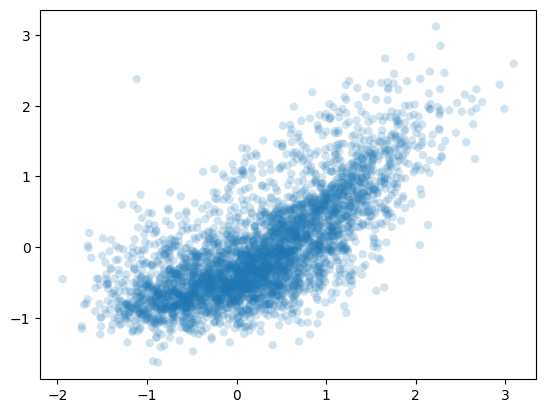

In [27]:
fig, ax = plt.subplots(1, 1)

ax.scatter(
    abundances[w_valid],
    cl_intensities[w_valid],
    lw=0., edgecolor='none',
    alpha=0.2,
)

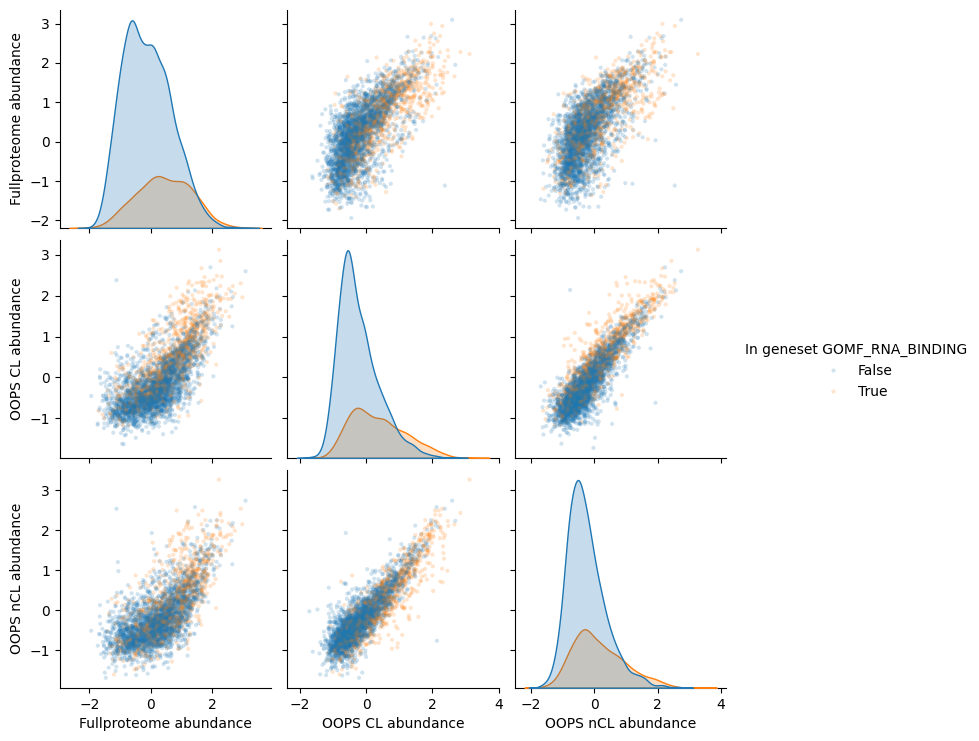

In [28]:
pg = seaborn.pairplot(
    data=pd.DataFrame({
        "Fullproteome abundance": abundances,
        "OOPS CL abundance": cl_intensities,
        "OOPS nCL abundance": ncl_intensities,
        "In geneset %s" % GS_NAME: w_in_gs,
    }, index=w_valid.index)[w_valid],
    hue="In geneset %s" % GS_NAME,
    plot_kws=dict(
        lw=0., edgecolor='none',
        alpha=0.2,
        s=3 ** 2,
    ),
)

# Somewhat hacky but it works
for ax in pg.axes.ravel():
    for child in ax.get_children():
        ctype = str(type(child))
        if "PathCollection" in ctype:
            child.set_rasterized(True)

pg.savefig("pipeline_activation/figures/pairplot.fp_cl_ncl.pdf")

---